In [1]:
from posebusters.posebusters import PoseBusters
from rdkit import Chem
import os
import pandas as pd
import re 
from typing import List

# Loading and processing results

In [2]:
from Approach import DockingApproach, DiffDockApproach, ICMApproach, ChaiApproach
def run_posebusters(
    approach: DockingApproach,
    base_outdir: str,
    data_dir: str,
    top_n: int = 5,
    docking: bool = False,
) -> pd.DataFrame:
    """
    For each protein subdir in base_outdir:
      - list up to top_n SDF files (method-specific naming)
      - run PoseBusters on each
      - parse a numeric score or confidence if available
      - collect results in a DataFrame
    """
    pb = PoseBusters(config="redock", top_n=None)
    method_name = approach.get_name()
    all_rows = []

    for protein_name in os.listdir(base_outdir):
        protein_dir = os.path.join(base_outdir, protein_name)
        if not os.path.isdir(protein_dir):
            continue

        # Retrieve up to top-N .sdf file paths
        sdf_paths = approach.list_top_n_files(protein_dir, top_n)
        if not sdf_paths:
            print(f"[{method_name}] No top-{top_n} SDF files found for {protein_name}")
            continue

        # References
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        if not (os.path.isfile(true_ligand) and os.path.isfile(protein_pdb)):
            print(f"[{method_name}] Missing reference for {protein_name}")
            continue

        rank_counter = 1
        for sdf_path in sdf_paths:
            try:
                df_pb = pb.bust(
                    mol_pred=sdf_path,
                    mol_true=true_ligand,
                    mol_cond=protein_pdb,
                    full_report=True
                )
                # parse numeric score or confidence if available
                numeric_score = approach.parse_score(sdf_path)

                df_pb["score"] = numeric_score  # or "confidence_score" or "docking_score"
                df_pb["method"] = method_name
                df_pb["protein"] = protein_name
                df_pb["rank"] = rank_counter
                rank_counter += 1

                all_rows.append(df_pb)
            except Exception as e:
                print(f"[{method_name}] [ERROR] PoseBusters failed for {protein_name}: {e}")

    if not all_rows:
        return pd.DataFrame()
    return pd.concat(all_rows, ignore_index=True)

In [7]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"

exp_name = "posebusters_benchmark_outputs_1"

# Initialize your approaches
approaches = [
    ICMApproach(),
    DiffDockApproach(),
    ChaiApproach(),
    # ... add more if needed
]

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/icm_manual_{exp_name}",
    "diffdock": f"{base_outdir}/Diffdock/inference/diffdock_posebusters_benchmark_output_orig_structure_1",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_{exp_name}",
    # ...
}

# The folder containing the real (crystal) ligand and protein PDB:
#  PoseBench/data/posebusters_benchmark_set/<protein>/
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"


In [ ]:
df_all = []

for approach in approaches:
    method_name = approach.get_name()
    base_outdir = BASE_DIRS[method_name]
    df_method = run_posebusters(
        approach,
        base_outdir=base_outdir,
        data_dir=DATA_DIR,
        top_n=5
    )
    df_all.append(df_method)

df_combined = pd.concat(df_all, ignore_index=True)
print(df_combined.shape)
df_combined.head()

# Now you have a single DataFrame with columns:
#   - 'protein'
#   - 'method' (icm / diffdock / chai-1)
#   - 'rank' (1..5)
#   - 'score' (NaN or a float)
#   - 'rmsd', 'rmsd_≤_2å', etc. from PoseBusters
# You can groupby or pivot as you wish.

In [23]:
df_combined.to_csv(f"{exp_name}_posebusters_results.csv", index=False)

# Overall Analysis

### Basic sumaries and Distributions 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [58]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"
exp_name = "posebusters_benchmark_outputs_1"
df_combined = pd.read_csv(f"{exp_name}_posebusters_results.csv")

In [59]:
df_combined.groupby("method")['method'].value_counts()

method
chai-1      1391
diffdock    1045
icm         1393
Name: count, dtype: int64

In [25]:
df_combined.groupby("method")["rmsd_≤_2å"].mean()

method
chai-1      0.373113
diffdock    0.445933
icm         0.307968
Name: rmsd_≤_2å, dtype: float64

In [26]:
df_combined.groupby("method")["rmsd_≤_2å"].value_counts()

method    rmsd_≤_2å
chai-1    False        872
          True         519
diffdock  False        579
          True         466
icm       False        964
          True         429
Name: count, dtype: int64

In [27]:
df_combined.groupby("method")["rmsd"].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
chai-1,1386.0,13.340099,16.460549,0.150232,1.009483,4.444497,23.500100,76.880064
diffdock,1045.0,9.075414,13.798702,0.166042,0.870341,2.585117,9.741777,80.435404
icm,1393.0,3.960575,3.286096,0.131945,1.729693,2.976135,5.444499,28.550944


**Top-1 overlapped proteins with diffdock**

In [28]:
common_proteins = df_combined.loc[df_combined["method"] == "diffdock", "protein"].unique()
df_icm_for_same_proteins = df_combined.loc[
    (df_combined["method"] == "icm") &
    (df_combined["protein"].isin(common_proteins))
]
df_icm_for_same_proteins['rmsd_≤_2å'].value_counts()
df_icm_for_same_proteins_top1 = df_icm_for_same_proteins.loc[
    df_icm_for_same_proteins.groupby("protein")["score"].idxmin()
]
df_icm_for_same_proteins_top1['rmsd_≤_2å'].value_counts()

rmsd_≤_2å
True     150
False     58
Name: count, dtype: int64

### Histograms and densities

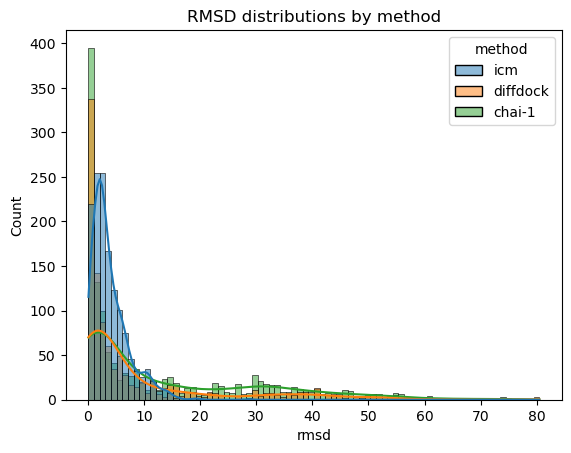

In [29]:
sns.histplot(data=df_combined, x="rmsd", hue="method", kde=True)
plt.title("RMSD distributions by method")
plt.show()

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_41590/1941873662.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)


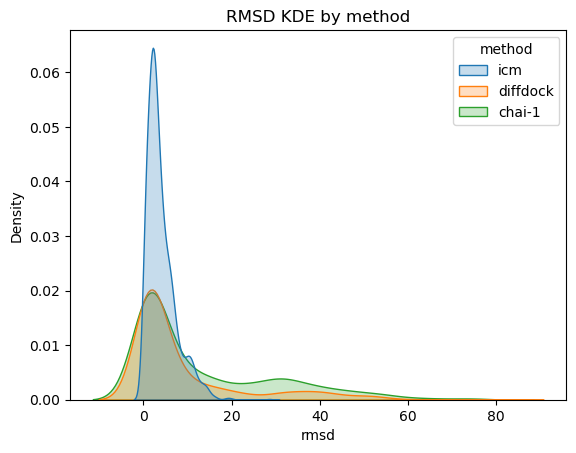

In [30]:
sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)
plt.title("RMSD KDE by method")
plt.show()

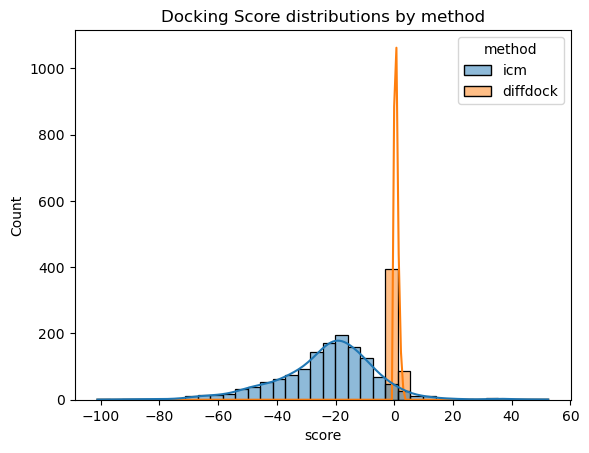

In [33]:
sns.histplot(data=df_combined.dropna(subset=["score"]), x="score", hue="method", kde=True)
plt.title("Docking Score distributions by method")
plt.show()

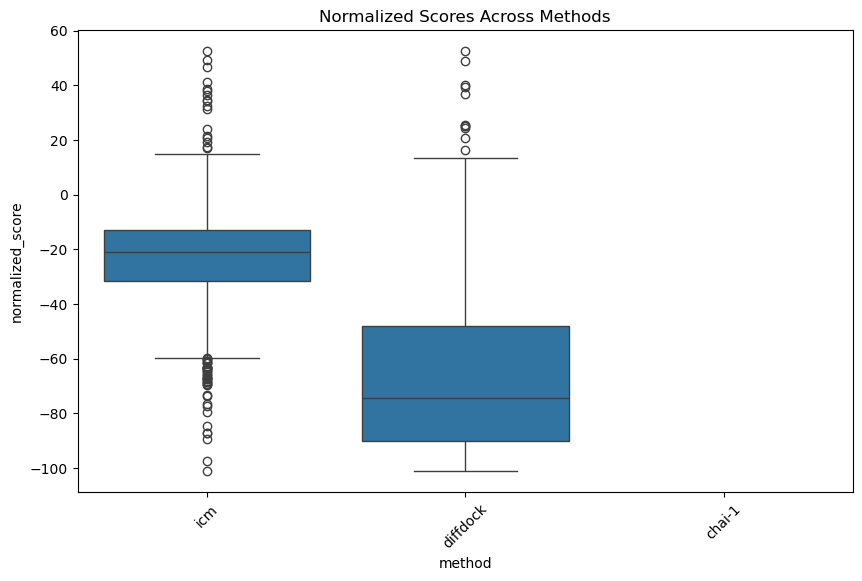

In [36]:
# Get ICM score range for scaling reference
icm_min = df_combined[df_combined['method'] == 'icm']['score'].min()
icm_max = df_combined[df_combined['method'] == 'icm']['score'].max()

# Create normalized scores column
def normalize_to_icm_scale(group):
    method = group['method'].iloc[0]
    if method == 'icm':
        return group['score']
    else:
        # Min-max normalization scaled to ICM range
        method_min = group['score'].min()
        method_max = group['score'].max()
        return (group['score'] - method_min) * (icm_max - icm_min) / (method_max - method_min) + icm_min

# Apply normalization
df_combined['normalized_score'] = df_combined.groupby('method').apply(normalize_to_icm_scale).reset_index(level=0, drop=True)

# Plot comparison
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='method', y='normalized_score')
plt.title('Normalized Scores Across Methods')
plt.xticks(rotation=45)
plt.show()

**Confidence/Score histograms**

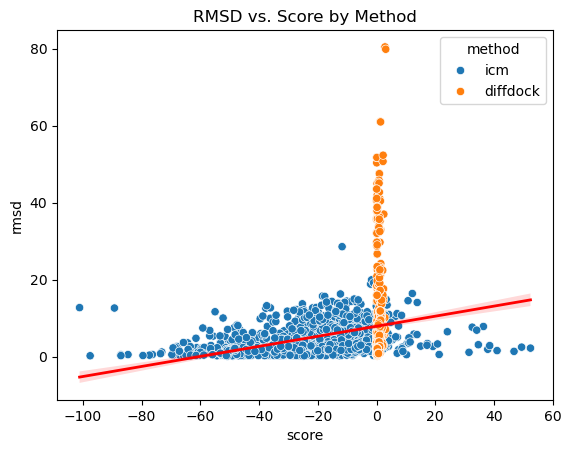

In [42]:
sns.scatterplot(
    data=df_combined.dropna(subset=["score"]), 
    x="score", 
    y="rmsd", 
    hue="method"
)

sns.regplot(
    data=df_combined,
    x="score",
    y="rmsd",
    scatter=False,  # Don't overlay the scatter points again
    color="red",    # Color of the regression line
    line_kws={"linewidth": 2}  # Line properties
)

plt.title("RMSD vs. Score by Method")
plt.show()

In [12]:
import plotly.express as px

fig = px.scatter(
    df_combined.dropna(subset=["score"]),
    x="score", y="rmsd", 
    color="rmsd_≤_2å",
    facet_col="method",
    hover_name="protein"
)
fig.show()

**Correlations among numeric columns:**

In [ ]:
numeric_cols = ["rmsd", "score", "some_other_metric"]
corr_matrix = df_all[numeric_cols].corr()
print(corr_matrix)

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Per-protein Analysis

**Success rate per protein**
Use this to  see which proteins are “easy” or “hard” for each metho

In [31]:
per_protein_method = df_combined.groupby(["protein","method"])["rmsd_≤_2å"].mean().reset_index()
per_protein_method.head()

,protein,method,rmsd_≤_2å
0,5SAK_ZRY,chai-1,0.8
1,5SAK_ZRY,diffdock,0.2
2,5SAK_ZRY,icm,0.4
3,5SB2_1K2,chai-1,1.0
4,5SB2_1K2,diffdock,1.0


In [32]:
success_pivot = per_protein_method.pivot(
    index="protein", 
    columns="method", 
    values="rmsd_≤_2å"
)
success_pivot.head()

method,chai-1,diffdock,icm
protein,,,
5SAK_ZRY,0.8,0.2,0.4
5SB2_1K2,1.0,1.0,0.2
5SD5_HWI,1.0,0.4,0.2
6M2B_EZO,1.0,0.8,0.6
6M73_FNR,1.0,1.0,0.4


**2. Minimum RMSD among top-N poses:**  compute the minimum RMSD per (protein, method) to see the best that method can do for each protein:

In [33]:
best_rmsd = df_combined.groupby(["protein","method"])["rmsd"].min().reset_index()
best_rmsd_pivot = best_rmsd.pivot(index="protein", columns="method", values="rmsd")
best_rmsd_pivot.head()

method,chai-1,diffdock,icm
protein,,,
5SAK_ZRY,0.935259,0.684621,0.791606
5SB2_1K2,0.380377,0.357419,0.301782
5SD5_HWI,1.285547,1.960022,0.760788
6M2B_EZO,0.460473,1.385349,0.261585
6M73_FNR,0.150232,0.298262,0.373483


## Pairwise or overlap analysis

**1. Which proteins are solved by multiple methods**

In [34]:
df_combined["success"] = df_combined["rmsd_≤_2å"]

In [35]:
# For each protein, count how many methods succeeded
success_counts = (
    df_combined[df_combined["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)
success_counts.head()

method,chai-1,diffdock,icm
protein,,,
5SAK_ZRY,True,True,True
5SB2_1K2,True,True,True
5SD5_HWI,True,True,True
6M2B_EZO,True,True,True
6M73_FNR,True,True,True


In [36]:
# For each proteins, count the overalapping methods
icm_diffdock_overlap = success_counts[["icm", "diffdock"]].all(axis=1).sum()
icm_chai_overlap = success_counts[["icm", "chai-1"]].all(axis=1).sum()
diffdock_chai_overlap = success_counts[["diffdock", "chai-1"]].all(axis=1).sum()
print(icm_diffdock_overlap, icm_chai_overlap, diffdock_chai_overlap)

104 131 81


In [37]:
print(success_counts['diffdock'].sum(), success_counts['chai-1'].sum(), success_counts['icm'].sum())
print(success_counts.sum())

109 138 263
method
chai-1      138
diffdock    109
icm         263
dtype: int64


### In-depth analysis for failed cases for ICM

In [48]:
failed_proteins = success_counts[success_counts['icm'] == False].index.tolist()
print(f"Proteins where ICM failed: {failed_proteins}")

# Optional: See full details for these proteins
icm_failures = df_combined[
    (df_combined['protein'].isin(failed_proteins)) & 
    (df_combined['method'] == 'icm')
]
# display(icm_failures)

Proteins where ICM failed: ['6TW7_NZB', '6YT6_PKE', '6ZAE_ACV', '7PK0_BYC', '7QE4_NGA', '7R3D_APR', '8B8H_OJQ', '8D19_GSH', '8HFN_XGC']


In [49]:
# 1. Get ICM failed proteins
icm_failed = success_counts[success_counts['icm'] == False].index

# 2. Create comparison table for failed proteins
failure_comparison = success_counts.loc[icm_failed]

# 3. Display results
print("Success/Failure patterns for ICM-failed proteins:")
display(failure_comparison)

Success/Failure patterns for ICM-failed proteins:


method,chai-1,diffdock,icm
protein,,,
6TW7_NZB,True,True,False
6YT6_PKE,True,True,False
6ZAE_ACV,True,False,False
7PK0_BYC,True,False,False
7QE4_NGA,True,True,False
7R3D_APR,True,False,False
8B8H_OJQ,False,True,False
8D19_GSH,False,True,False
8HFN_XGC,True,False,False


In [38]:
for method in ["icm", "diffdock", "chai-1"]:
    tmp = df_combined.loc[df_combined['method']== method]
    tmp = tmp.loc[tmp['rank'] == 1]
    print(tmp['success'].value_counts())

success
True     204
False     75
Name: count, dtype: int64
success
False    115
True      94
Name: count, dtype: int64
success
False    161
True     119
Name: count, dtype: int64


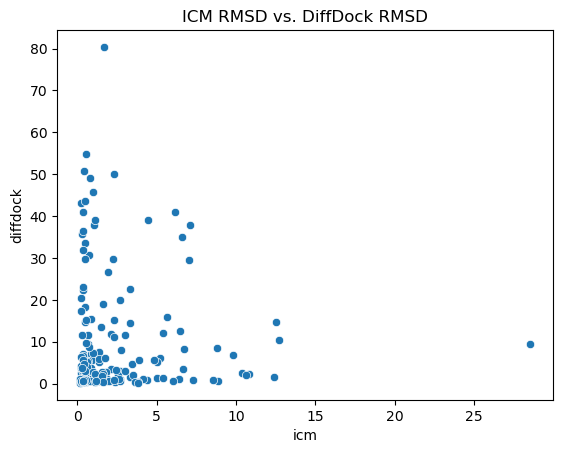

In [39]:
# Suppose we only compare rank=1 for each method
# (or min RMSD across top5)
# Then pivot:
pivot_df = df_combined[df_combined["rank"]==1].pivot(
    index="protein",
    columns="method",
    values="rmsd"
)
sns.scatterplot(
    data=pivot_df,
    x="icm",
    y="diffdock"
)
plt.title("ICM RMSD vs. DiffDock RMSD")
plt.show()

In [23]:
fig = px.scatter(
    pivot_df,
    x="icm",
    y="diffdock",
    hover_name=pivot_df.index
)
fig.show()

In [54]:
df_combined['rmsd'] = np.log1p(df_combined['rmsd'])

### plot_rmsd_comparisons

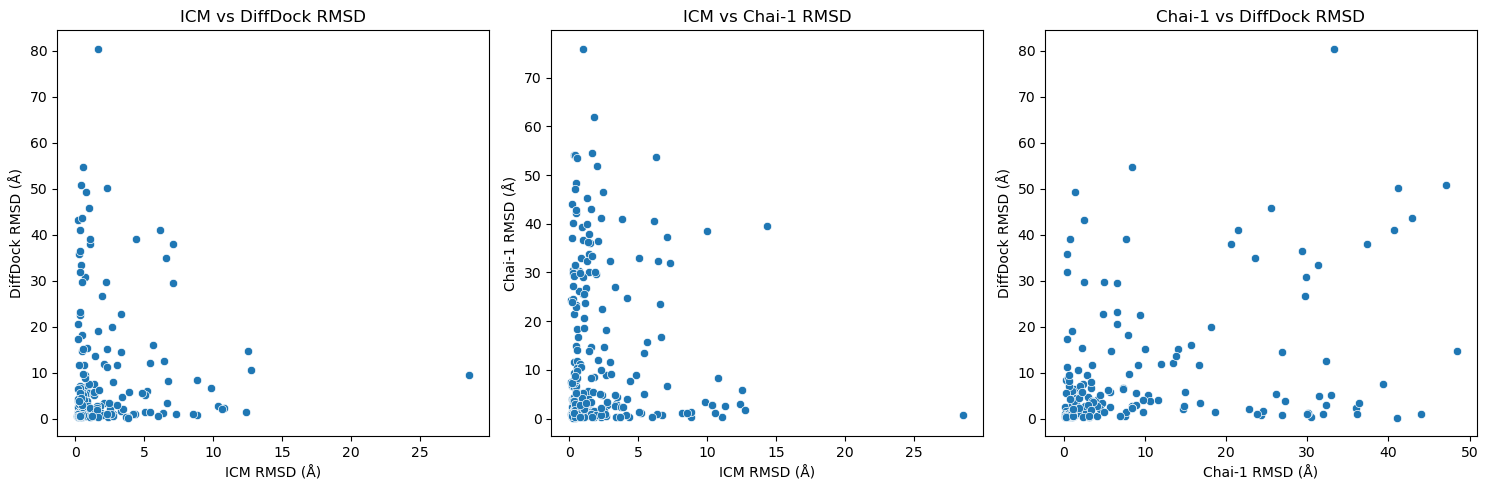

In [52]:
# plot_rmsd_comparisons.py

# Create subplots for all three comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# ICM vs DiffDock
sns.scatterplot(data=pivot_df, x='icm', y='diffdock', ax=ax1)
ax1.set_xlabel('ICM RMSD (Å)')
ax1.set_ylabel('DiffDock RMSD (Å)')
ax1.set_title('ICM vs DiffDock RMSD')

# ICM vs Chai-1
sns.scatterplot(data=pivot_df, x='icm', y='chai-1', ax=ax2)
ax2.set_xlabel('ICM RMSD (Å)')
ax2.set_ylabel('Chai-1 RMSD (Å)')
ax2.set_title('ICM vs Chai-1 RMSD')

# Chai-1 vs DiffDock
sns.scatterplot(data=pivot_df, x='chai-1', y='diffdock', ax=ax3)
ax3.set_xlabel('Chai-1 RMSD (Å)')
ax3.set_ylabel('DiffDock RMSD (Å)')
ax3.set_title('Chai-1 vs DiffDock RMSD')

plt.tight_layout()
plt.show()

## 6. Model-Fitting or Statistical Analysis

In [ ]:
import statsmodels.formula.api as smf

df_subset = df_all.dropna(subset=["rmsd", "num_rotatable_bonds"])
model = smf.ols("rmsd ~ num_rotatable_bonds + C(method)", data=df_subset).fit()
print(model.summary())